In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

In [103]:
# read data
raw = pd.read_csv('data.csv')
print(raw.shape)
raw.head()

(30697, 25)


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [104]:
# count how many NaN in each column
# 'shot_made_flag' has 5000 NaN
raw.isna().sum()

action_type              0
combined_shot_type       0
game_event_id            0
game_id                  0
lat                      0
loc_x                    0
loc_y                    0
lon                      0
minutes_remaining        0
period                   0
playoffs                 0
season                   0
seconds_remaining        0
shot_distance            0
shot_made_flag        5000
shot_type                0
shot_zone_area           0
shot_zone_basic          0
shot_zone_range          0
team_id                  0
team_name                0
game_date                0
matchup                  0
opponent                 0
shot_id                  0
dtype: int64

In [105]:
# get rid of raws with NaN, 5000 raws
kobe = raw[raw.shot_made_flag.notna()]
print(kobe.shape)

(25697, 25)


Text(0.5, 1.0, 'lon and lat')

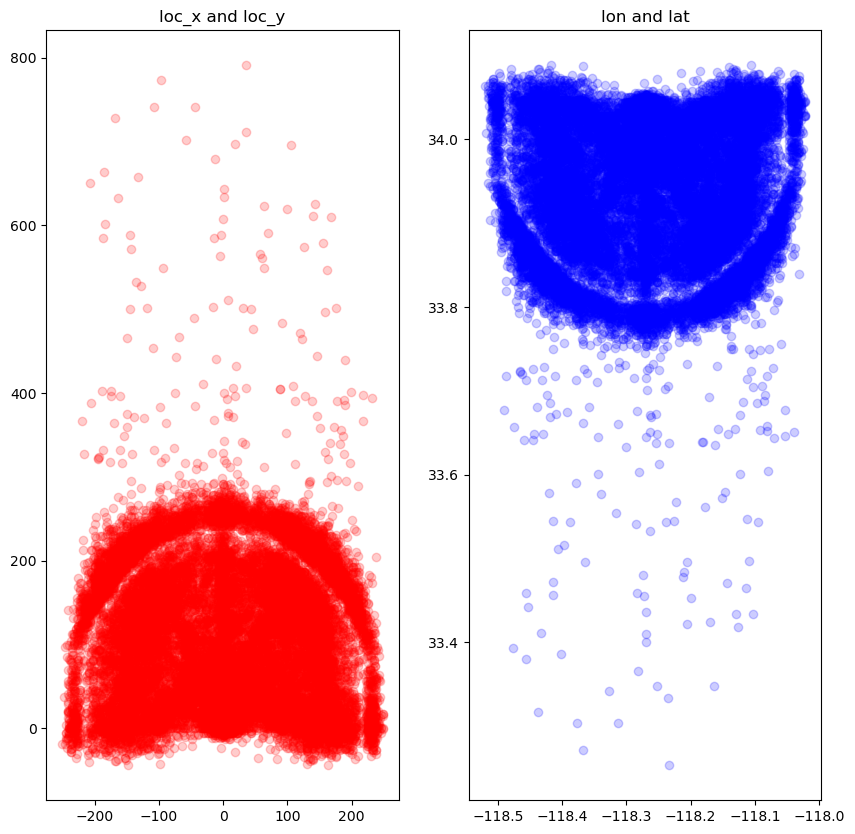

In [106]:
# shot pos
# 两组特征十分相似，之后只需要用到一组即可
alpha = 0.2  # 透明度
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.scatter(kobe.loc_x, kobe.loc_y, color='r', alpha=alpha)
plt.title('loc_x and loc_y')

plt.subplot(122)
plt.scatter(kobe.lon, kobe.lat, color='b', alpha=alpha)
plt.title('lon and lat')

In [107]:
# 投篮角度
raw['dist'] = np.sqrt(raw.loc_x ** 2 + raw.loc_y ** 2)
loc_x_zero = raw.loc_x == 0

raw['angle'] = np.array([0]*len(raw))  # set default as 0
raw['angle'][~loc_x_zero] = np.arctan(raw['loc_y'][~loc_x_zero]/raw['loc_x'][~loc_x_zero])  # 取到所有loc_x_zero中为False的行
raw['angle'][loc_x_zero] = np.pi/2
raw['angle']

/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_61893/3073672659.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['angle'][~loc_x_zero] = np.arctan(raw['loc_y'][~loc_x_zero]/raw['loc_x'][~loc_x_zero])  # 取到所有loc_x_zero中为False的行
/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_61893/3073672659.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw['angle'][loc_x_zero] = np.pi/2


0        0.407058
1       -0.000000
2       -0.928481
3        0.903063
4        1.570796
           ...   
30692    1.549966
30693    1.570796
30694   -0.891663
30695    1.455209
30696    1.556908
Name: angle, Length: 30697, dtype: float64

In [108]:
raw['remaining_time'] = raw.minutes_remaining * 60 + raw.seconds_remaining
# raw.remaining_time

0        627
1        622
2        465
3        412
4        379
        ... 
30692    365
30693    365
30694    208
30695    130
30696     39
Name: remaining_time, Length: 30697, dtype: int64

In [109]:
# print(raw.action_type.unique(), '\n')  # 某一列去重
# print(kobe.shot_type.value_counts())

['Jump Shot' 'Driving Dunk Shot' 'Layup Shot' 'Running Jump Shot'
 'Driving Layup Shot' 'Reverse Layup Shot' 'Reverse Dunk Shot'
 'Slam Dunk Shot' 'Turnaround Jump Shot' 'Tip Shot' 'Running Hook Shot'
 'Alley Oop Dunk Shot' 'Dunk Shot' 'Alley Oop Layup shot'
 'Running Dunk Shot' 'Driving Finger Roll Shot' 'Running Layup Shot'
 'Finger Roll Shot' 'Fadeaway Jump Shot' 'Follow Up Dunk Shot' 'Hook Shot'
 'Turnaround Hook Shot' 'Running Tip Shot' 'Jump Hook Shot'
 'Running Finger Roll Shot' 'Jump Bank Shot' 'Turnaround Finger Roll Shot'
 'Hook Bank Shot' 'Driving Hook Shot' 'Running Reverse Layup Shot'
 'Driving Finger Roll Layup Shot' 'Fadeaway Bank shot' 'Pullup Jump shot'
 'Finger Roll Layup Shot' 'Turnaround Fadeaway shot'
 'Driving Reverse Layup Shot' 'Driving Slam Dunk Shot'
 'Step Back Jump shot' 'Reverse Slam Dunk Shot' 'Turnaround Bank shot'
 'Running Finger Roll Layup Shot' 'Floating Jump shot'
 'Putback Slam Dunk Shot' 'Running Bank shot' 'Driving Bank shot'
 'Putback Layup Shot'

In [110]:
raw['season'] = raw['season'].apply(lambda x: int(x.split('-')[1]) )
raw['season'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 97,
       98, 99,  0])

Text(0.5, 1.0, 'dist and shot_dist')

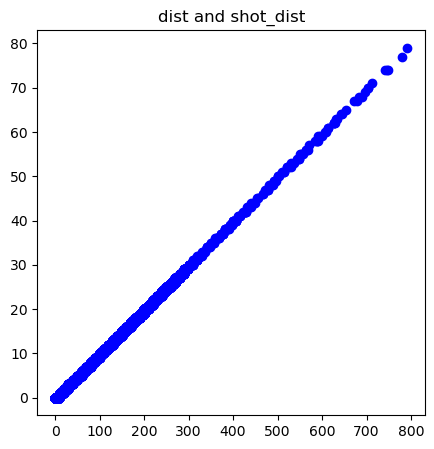

In [111]:
# 两个特征存在线性相关性，二选一
plt.figure(figsize=(5,5))
plt.scatter(raw.dist, raw.shot_distance, color='b')
plt.title('dist and shot_dist')

In [112]:
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range', 'shot_zone_basic', \
         'matchup', 'lon', 'lat', 'seconds_remaining', 'minutes_remaining', \
         'shot_distance', 'loc_x', 'loc_y', 'game_event_id', 'game_id', 'game_date']
for drop in drops:
    raw = raw.drop(drop, 1)

/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_61893/2805507943.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  raw = raw.drop(drop, 1)
/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_61893/2805507943.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  raw = raw.drop(drop, 1)
/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_61893/2805507943.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  raw = raw.drop(drop, 1)
/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_61893/2805507943.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  raw = raw.drop(drop, 1)
/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh

In [113]:
raw

,action_type,combined_shot_type,period,playoffs,season,shot_made_flag,shot_type,opponent,dist,angle,remaining_time
0,Jump Shot,Jump Shot,1,0,1,NaN,2PT Field Goal,POR,181.859836,0.407058,627
1,Jump Shot,Jump Shot,1,0,1,0.0,2PT Field Goal,POR,157.000000,-0.000000,622
2,Jump Shot,Jump Shot,1,0,1,1.0,2PT Field Goal,POR,168.600119,-0.928481,465
3,Jump Shot,Jump Shot,1,0,1,0.0,2PT Field Goal,POR,222.865430,0.903063,412
4,Driving Dunk Shot,Dunk,2,0,1,1.0,2PT Field Goal,POR,0.000000,1.570796,379
...,...,...,...,...,...,...,...,...,...,...,...
30692,Jump Shot,Jump Shot,4,1,0,0.0,2PT Field Goal,IND,48.010416,1.549966,365
30693,Tip Shot,Tip Shot,4,1,0,NaN,2PT Field Goal,IND,0.000000,1.570796,365
30694,Running Jump Shot,Jump Shot,4,1,0,1.0,2PT Field Goal,IND,213.335417,-0.891663,208
30695,Jump Shot,Jump Shot,4,1,0,0.0,3PT Field Goal,IND,268.793601,1.455209,130


In [114]:
# print (raw['combined_shot_type'].value_counts())
#
# # 对于'combined_shot_type'列中所有的非重项各创建新的一列，存在的行是1，不存在的行是0
# pd.get_dummies(raw['combined_shot_type'], prefix='combined_shot_type')[0:2]

In [115]:
# 将指定的几列变成one-hot编码
categorical_vars = ['action_type', 'combined_shot_type', 'shot_type', 'opponent', 'period', 'season']
for var in categorical_vars:
    raw = pd.concat([raw, pd.get_dummies(raw[var], prefix=var)], 1)
    raw = raw.drop(var, 1)
raw

/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_61893/1966995271.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  raw = pd.concat([raw, pd.get_dummies(raw[var], prefix=var)], 1)
/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_61893/1966995271.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  raw = raw.drop(var, 1)
/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_61893/1966995271.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  raw = pd.concat([raw, pd.get_dummies(raw[var], prefix=var)], 1)
/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_61893/1966995271.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  raw =

,playoffs,shot_made_flag,dist,angle,remaining_time,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,action_type_Cutting Finger Roll Layup Shot,action_type_Cutting Layup Shot,action_type_Driving Bank shot,...,season_10,season_11,season_12,season_13,season_14,season_15,season_16,season_97,season_98,season_99
0,0,NaN,181.859836,0.407058,627,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.0,157.000000,-0.000000,622,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1.0,168.600119,-0.928481,465,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.0,222.865430,0.903063,412,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1.0,0.000000,1.570796,379,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,1,0.0,48.010416,1.549966,365,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30693,1,NaN,0.000000,1.570796,365,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30694,1,1.0,213.335417,-0.891663,208,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30695,1,0.0,268.793601,1.455209,130,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
# 不为NaN的作为训练组
train_kobe = raw[pd.notnull(raw['shot_made_flag'])]
train_label = train_kobe['shot_made_flag']  # 是否命中作为标签
train_kobe = train_kobe.drop('shot_made_flag', 1)

# 将'shot_made_flag'中为NaN的行取出作为测试组
test_kobe = raw[pd.isnull(raw['shot_made_flag'])]
test_kobe = test_kobe.drop('shot_made_flag', 1)

/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_61893/2361450862.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_kobe = train_kobe.drop('shot_made_flag', 1)
/var/folders/vr/1f01f57n6l13s5_b3yh9ztsh0000gn/T/ipykernel_61893/2361450862.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_kobe = test_kobe.drop('shot_made_flag', 1)


In [117]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix,log_loss
import time

# range_m = np.logspace(0, 2, num=3).astype(int)
# range_m

In [119]:
# # find the best n_estimators for RandomForestClassifier
# find the number of trees in the forest
print('Finding best n_estimators for RandomForestClassifier...')
min_score = 100000
best_n = 0
scores_n = []
range_n = np.logspace(0,2,num=3).astype(int)
for n in range_n:
    print("the number of trees : {0}".format(n))
    t1 = time.time()

    rfc_score = 0.
    # 创建模型
    rfc = RandomForestClassifier(n_estimators=n)
    kf = KFold(n_splits=10, shuffle=True)
    # 返回分好的train和test的index， 用train的部分去做
    for train_k, test_k in kf.split(train_kobe):
        rfc.fit(train_kobe.iloc[train_k], train_label.iloc[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(train_kobe.iloc[test_k])
        rfc_score += log_loss(train_label.iloc[test_k], pred) / 10
    scores_n.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_n = n

    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(n, t2-t1))
print(best_n, min_score)


# find best max_depth for RandomForestClassifier
# The maximum depth of the tree
print('Finding best max_depth for RandomForestClassifier...')
min_score = 100000
best_m = 0
scores_m = []
range_m = np.logspace(0,2,num=3).astype(int)
for m in range_m:
    print("the max depth : {0}".format(m))
    t1 = time.time()

    rfc_score = 0.
    rfc = RandomForestClassifier(max_depth=m, n_estimators=best_n)
    kf = KFold(n_splits=10, shuffle=True)
    for train_k, test_k in kf.split(train_kobe):
        rfc.fit(train_kobe.iloc[train_k], train_label.iloc[train_k])
        #rfc_score += rfc.score(train.iloc[test_k], train_y.iloc[test_k])/10
        pred = rfc.predict(train_kobe.iloc[test_k])
        rfc_score += log_loss(train_label.iloc[test_k], pred) / 10
    scores_m.append(rfc_score)
    if rfc_score < min_score:
        min_score = rfc_score
        best_m = m

    t2 = time.time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(m, t2-t1))
print(best_m, min_score)

Finding best n_estimators for RandomForestClassifier...
the number of trees : 1
Done processing 1 trees (0.717sec)
the number of trees : 10
Done processing 10 trees (4.346sec)
the number of trees : 100
Done processing 100 trees (39.854sec)
100 11.806455503886694
Finding best max_depth for RandomForestClassifier...
the max depth : 1
Done processing 1 trees (4.615sec)
the max depth : 10
Done processing 10 trees (13.793sec)
the max depth : 100
Done processing 100 trees (39.440sec)
10 11.001356478535424


Text(0.5, 0, 'max depth')

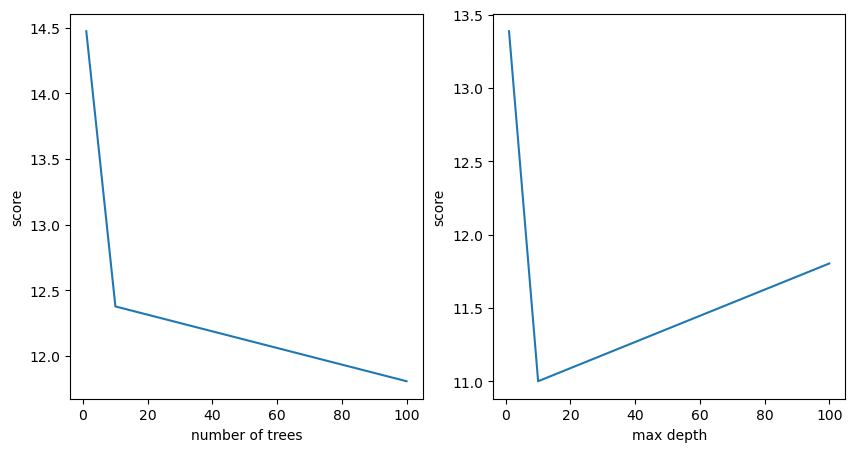

In [120]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(range_n, scores_n)
plt.ylabel('score')
plt.xlabel('number of trees')

plt.subplot(122)
plt.plot(range_m, scores_m)
plt.ylabel('score')
plt.xlabel('max depth')

In [121]:
model = RandomForestClassifier(n_estimators=best_n, max_depth=best_m)
model.fit(train_kobe, train_label)

RandomForestClassifier(max_depth=10)